<a href="https://colab.research.google.com/github/noallynoclan/colab/blob/master/230319_waterfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import colors
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')

,ds,is_A,is_B,rev
0,2022-01-01,0,0,100
1,2022-01-01,1,0,10
2,2022-01-01,1,1,5
3,2023-01-01,0,0,120
4,2023-01-01,1,0,15
5,2023-01-01,1,1,7


In [24]:

class waterfall:
    def __init__(self, data, features, target="rev", old_ds=None, new_ds=None):
        self.old_ds = old_ds or data["ds"].astype(str).min()
        self.new_ds = new_ds or data["ds"].astype(str).max()
        self.target = target
        self.intercept = "global_macro"
        self.features = list(set(features).union([self.intercept]))
        self.df = self.prep(
            data, self.target, self.features, self.intercept, self.old_ds, self.new_ds
        )
        self.reg, self.coef = self.fit(self.df[self.df[self.old_ds] > 0], self.features)
        self.df = self.predict(
            self.df, self.features, self.old_ds, self.new_ds, self.reg
        )

    @staticmethod
    def prep(data, target, features, intercept, old_ds, new_ds):
        df = data.copy()
        df[intercept] = 1
        df = (
            df[data["ds"].isin([old_ds, new_ds])]
            .pivot_table(target, features, "ds", "sum", 0)
            .reset_index()
        )
        df["y"] = df[new_ds] / df[old_ds] - 1
        df["w"] = df[old_ds] / df[old_ds].sum() * df[old_ds].count()
        return df

    @staticmethod
    def fit(df, features):
        reg = LinearRegression(fit_intercept=False)
        reg.fit(df[features], df["y"], sample_weight=df["w"])
        coef = dict(zip(features, reg.coef_))
        print({k: f"{v:+.1%}" for k, v in coef.items()})
        return reg, coef

    @staticmethod
    def predict(df, features, old_ds, new_ds, reg):
        df["y_pred"] = reg.predict(df[features])
        df["pred"] = (1 + df["y_pred"]) * df[old_ds]
        df["residual"] = df["pred"] - df[new_ds]
        df["ae"] = df["residual"].abs()
        return df

    def explore(self, data, cols, ax=None, size=12):
        df = self.prep(data, self.target, self.features, self.intercept, self.old_ds, self.new_ds)
        df = self.predict(df, self.features, self.old_ds, self.new_ds, self.reg)
        impact = (
            df[self.features].mul(pd.Series(self.coef)).mul(df[self.old_ds], axis=0)
        )
        impact.columns = map(lambda x: x.replace("_", "\n"), impact.columns)
        df = df.join(impact)
        vals = [self.old_ds, self.new_ds, "pred", *impact.columns]
        pt = df.pivot_table(vals, cols, None, "sum", 0, 1)[vals]
        for col in impact.columns:
            pt[col] = pt[col] / pt[self.old_ds]
        pt["y_true"] = pt[self.new_ds] / pt[self.old_ds] - 1
        pt["y_pred"] = pt["pred"] / pt[self.old_ds] - 1

        mask = (pt == pt) & (
            [col in [self.old_ds, self.new_ds, "pred"] for col in pt.columns]
        )
        if not ax:
            fig, ax = plt.subplots(1, 1, figsize=(len(self.features) / 2 + 5, len(pt) / 2))
        sns.heatmap(
            pt,
            mask=~mask,
            annot=True,
            annot_kws={"size": size},
            fmt=",.1f",
            cmap=colors.LinearSegmentedColormap.from_list("", ["white", "dodgerblue"]),
            cbar=False,
            ax=ax,
        )
        sns.heatmap(
            pt,
            mask=mask,
            annot=True,
            annot_kws={"size": size},
            fmt=",.1%",
            cmap=colors.LinearSegmentedColormap.from_list(
                "", ["orangered", "white", "limegreen"]
            ),
            cbar=False,
            ax=ax,
            vmin=-1,
            vmax=1,
        )

    def plot(self, data, title=None, ax=None, w=0.5, size=12):
        df = self.prep(data, self.target, self.features, self.intercept, self.old_ds, self.new_ds)
        res = pd.DataFrame.from_dict(
            {col: [df[df[col] == 1][self.old_ds].sum()] for col in self.coef.keys()},
            orient="index",
            columns=["segment"],
        )
        res["coef"] = res.index.map(self.coef)
        res["impact"] = res["segment"] * res["coef"]
        res = res.sort_values("impact")
        if not ax:
            fig, ax = plt.subplots(1, 1, figsize=(14, 6))
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        old = df[self.old_ds].sum()
        new = df[self.new_ds].sum()
        margin = 0.001 * size * max(old, new)

        b = old
        ax.bar(0, b, w, color="gray")
        ax.annotate(
            f"{self.old_ds}:\n{old:.1f}",
            [0, b + margin],
            fontsize=size,
            ha="center",
            va="bottom",
        )
        for j, (i, row) in enumerate(res.iterrows(), start=1):
            h = row["impact"]
            c = "limegreen" if h > 0 else "orangered"
            ax.bar(j, h, w, b, color=c)
            ax.plot([j - 1 - w / 2, j + w / 2], [b, b], c="k", ls="--", lw=1)

            ax.annotate(
                f'Segment:\n[{row["segment"] / old:.1%}]\n({row["coef"]:+.1%})',
                [j, max(b, b + h) + margin],
                fontsize=size,
                ha="center",
                va="bottom",
                color="gray",
            )
            ax.annotate(
                f"Change:\n{h:+.1f}\n({h/old:+.1%})",
                [j, min(b, b + h) - margin],
                fontsize=size,
                ha="center",
                va="top",
            )
            b += h
        else:
            ax.bar(j + 1, new, w, color="gray")
            ax.plot([j - w / 2, j + 1 + w / 2], [b, b], c="k", ls="--", lw=1)
            ax.annotate(
                f"{self.new_ds}:\n{new:.1f}\n({new / old-1:+.1%})",
                [j + 1, b + margin],
                fontsize=size,
                ha="center",
                va="bottom",
            )
        ax.set_xticks(range(len(self.features) + 2))
        ax.set_xticklabels(
            [self.old_ds, *map(lambda x: x.replace("_", "\n"), res.index), self.new_ds],
            size=size,
        )
        ax.set_ylim([ax.get_ylim()[0], max(old, new) * 1.2])
        if title:
            ax.set_title(title, size=1.5 * size)




{'is_B': '-32.2%', 'is_A': '+38.1%', 'global_macro': '+19.3%'}


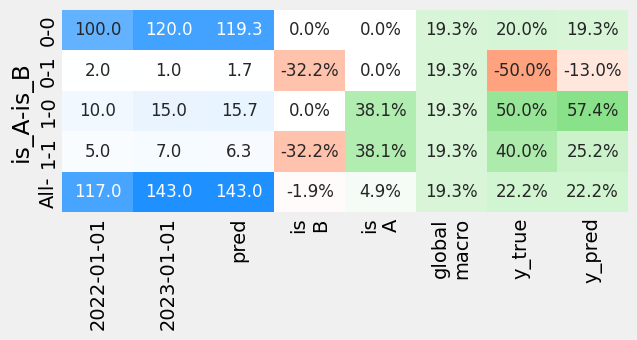

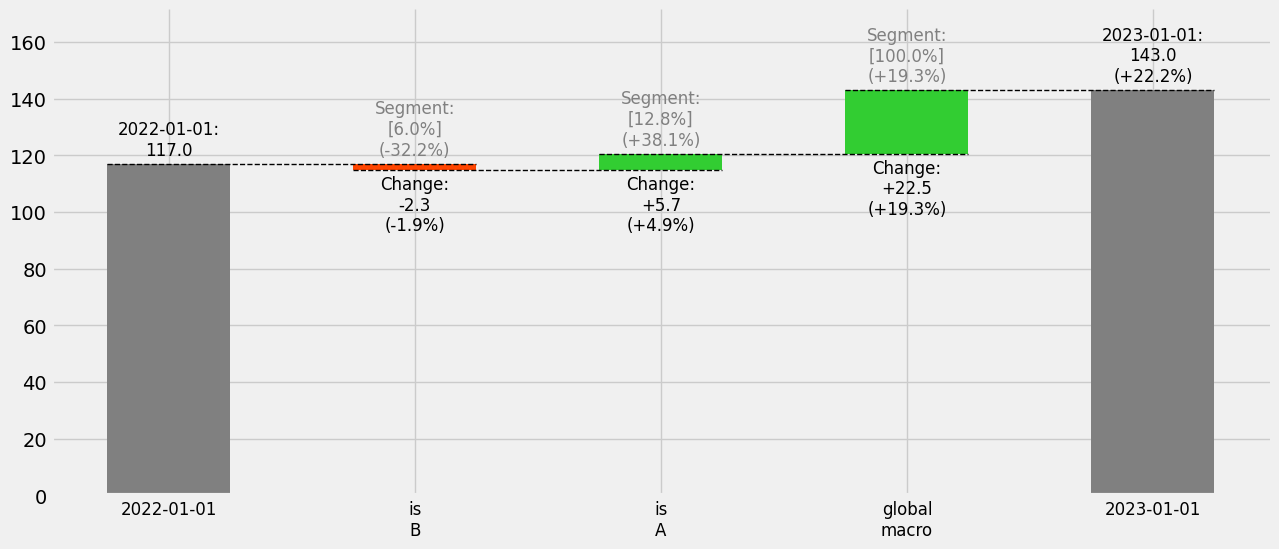

In [27]:
df = pd.DataFrame([
    ['2022-01-01', 0, 0, 100],
    ['2022-01-01', 1, 0, 10],
    ['2022-01-01', 1, 1, 5],
    ['2022-01-01', 0, 1, 2],
    ['2023-01-01', 0, 0, 120],
    ['2023-01-01', 1, 0, 15],
    ['2023-01-01', 1, 1, 7],
    ['2023-01-01', 0, 1, 1],
], columns=['ds', 'is_A', 'is_B', 'rev'])
df

features = ['is_A', 'is_B']
wf = waterfall(df, features=features)
wf.explore(df, features)
wf.plot(df)